# Multinomial distribution - pre-election polling
From Gelman et al:

*For a simple example of a multinomial model, we consider a sample survey question with three possible responses. In late October, 1988, a survey was conducted by CBS News of 1447 adults in the United States to find out their preferences in the upcoming presidential election.*

*Out of 1447 persons, $y_1 = 727$ supported George Bush, $y_2 = 583$ supported Michael Dukakis, and $y_3 = 137$ supported other candidates or expressed no opinion. Assuming no other information on the respondents, the 1447 observations are exchangeable. If we also assume simple random sampling (that is, 1447 names 'drawn out of a hat'), then the data $(y_1,\ y_2,\ y_3)$ follow a multinomial distribution, with parameters $(\theta_1,\ \theta_2,\ \theta_3)$, the proportions of Bush supporters, Dukakis supporters, and those with no opinion in the survey population. An estimand of interest is $\theta_1 - \theta_2$, the population difference in support for the two major candidates.*



In [1]:
data = [727,583,137]

In [2]:
import scipy.stats as stats
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpltern

from cmdstanpy import CmdStanModel

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"


plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

import pandas as pd

In this notebook we are using additional package [```mpltern``` ](https://mpltern.readthedocs.io/en/latest/index.html) which will be used for visualising simplexes.

In [3]:
func_dict = {
     "median": lambda x: np.percentile(x, 50),
     "5%": lambda x: np.percentile(x, 5),
     "95%": lambda x: np.percentile(x, 95)
 }

## Prior predictive distribution

In [4]:
with open('election_ppc.stan', 'r') as file:
    print(file.read())

data {
  int K; // number of categories
  int N; // total votes
}
generated quantities {
  simplex[K] theta = dirichlet_rng(rep_vector(1, K));
  int y_ppc[K] = multinomial_rng(theta,N);
}



In [5]:
model_ppc = CmdStanModel(stan_file='election_ppc.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpbkrz1f_2/tmp5i0alruy
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 5 - Multiparameter models/Multinomial election/election_ppc


In [6]:
ppc = model_ppc.sample(data=dict(K = 3,N = np.sum(data)),
                       seed=13052020,
                       fixed_param=True,
                       chains=1,
                       iter_sampling=1000,
                       refresh=1000,
                       iter_warmup=0)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [46]:
ppc.draws_pd().iloc[:,2:8].to_numpy()
names = list(ppc.draws_pd().iloc[:,2:8].columns)
order = [0,3,1,4,2,5]
names = [names[i] for i in order]
y_ppc = ppc.draws_pd().loc[:,names].to_numpy()
titles = [r'$\theta[1]$', 
          '$y_{ppc}[1]$',
          r'$\theta[2]$',
          '$y_{ppc}[2]$',
          r'$\theta[3]$',
          '$y_{ppc}[3]$']


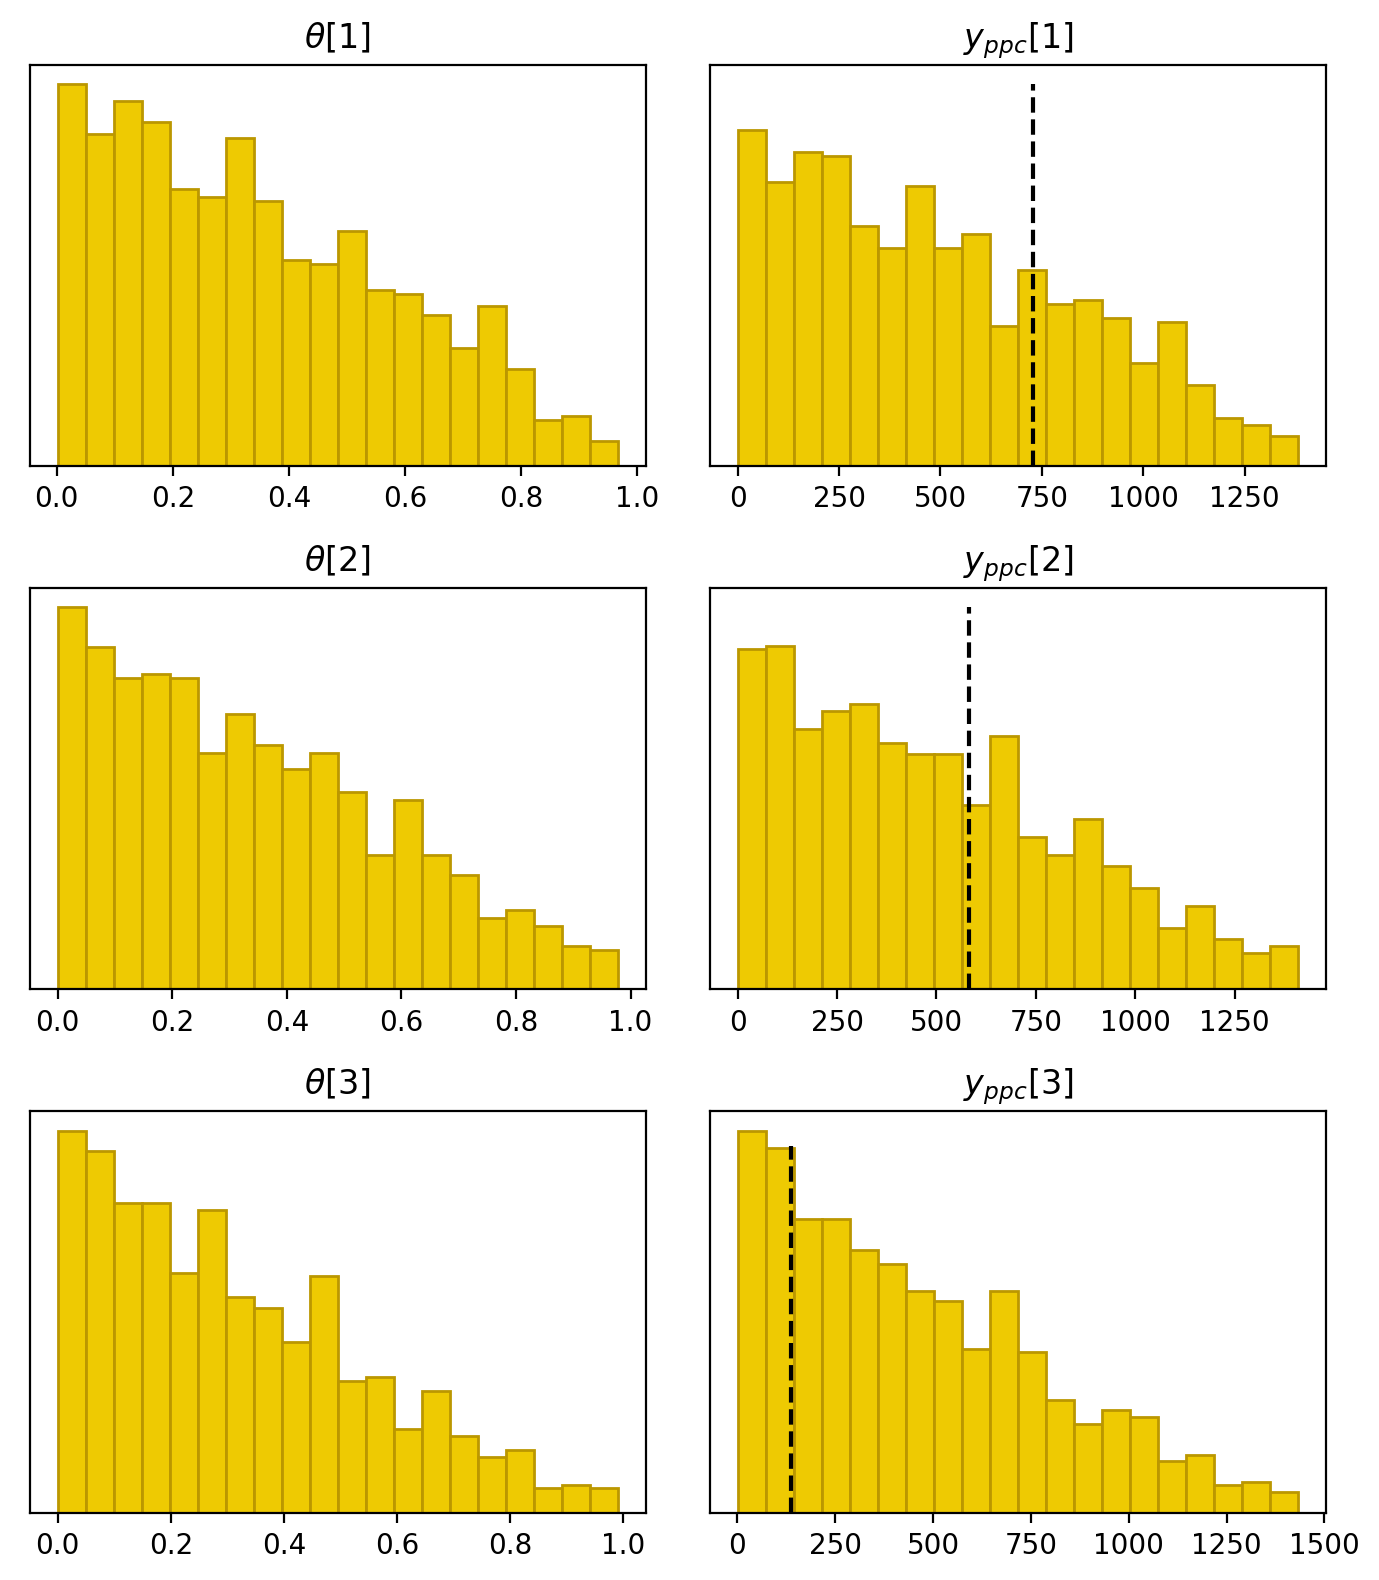

In [47]:
fig, axes = plt.subplots(3, 2, figsize=(7, 8), squeeze=False)
axes_flat=axes.flatten()
tvs=iter(data)
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_ppc[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(titles[k])
    if (k % 2) == 1:
        tv = next(tvs)
        ax.plot([tv,tv],[0,0.0015],linestyle='--',color='black') 
    ax.set_yticks([])


fig.tight_layout()

plt.show()

### Samples from joint distribution of $\theta$

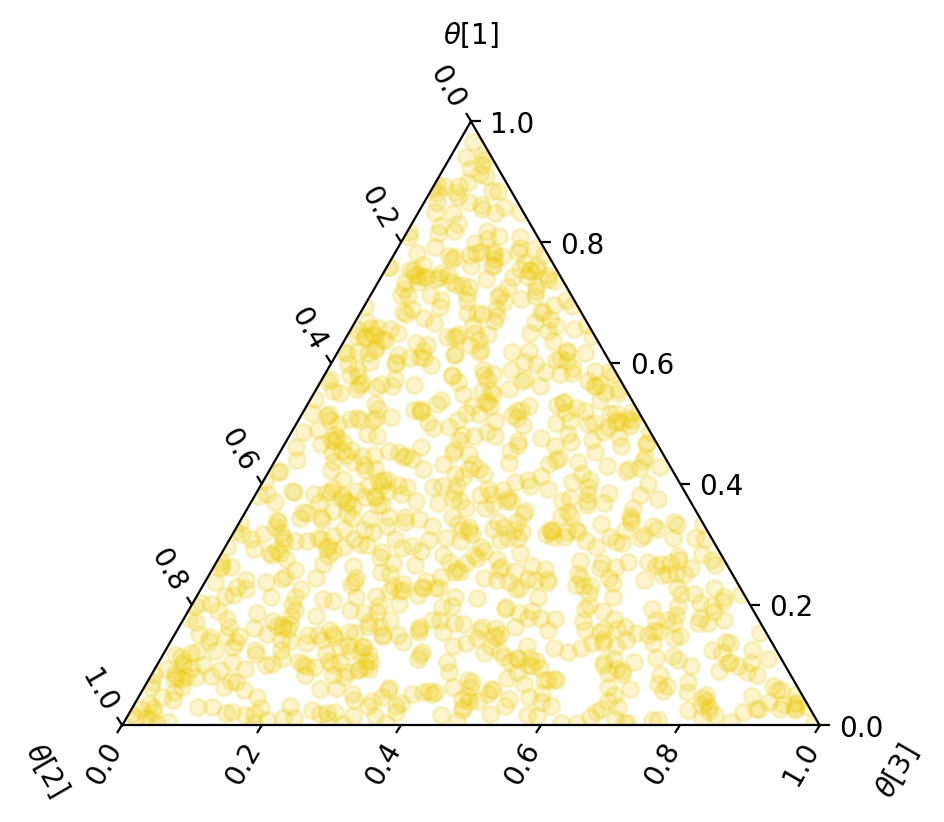

In [28]:
fig, ax_tr = plt.subplots(1, 1, figsize=(7, 4),subplot_kw={'projection':'ternary'})
ax_tr.set_tlabel(r'$\theta[1]$')
ax_tr.set_llabel(r'$\theta[2]$')
ax_tr.set_rlabel(r'$\theta[3]$')
ax_tr.scatter(y_ppc[:,0], y_ppc[:,2], y_ppc[:,4],alpha=0.2,color=dark)
plt.show()

























































## Posterior analysis and predictions

In [30]:
with open('election_fit_gq.stan', 'r') as file:
    print(file.read())
model_gq = CmdStanModel(stan_file='election_fit_gq.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpaujh0c9s/tmps9nr1lp_
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
data {
  int K; // number of categories
  int y[K]; //result of survey
}

parameters {
  simplex[K] theta;
}

model {
  y ~ multinomial(theta);
}
generated quantities {
  int y_sim[K];
  real advantage = theta[1]-theta[2];
  {
    int n;
    n = sum(y);
    y_sim = multinomial_rng(theta,n);
  }
}

INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 5 - Multiparameter models/Multinomial election/election_fit_gq


In [31]:
dane = dict(K = 3,y = data)

In [33]:
fit = model_gq.sample(data=dane, seed=27042020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


In [34]:
az.summary(fit,stat_funcs=func_dict,extend=False,var_names=['theta','y_sim'])

,median,5%,95%
theta[0],0.502,0.480,0.524
theta[1],0.403,0.382,0.424
theta[2],0.095,0.083,0.109
y_sim[0],726.000,682.000,770.000
y_sim[1],583.000,539.950,626.000
y_sim[2],138.000,112.000,165.000


In [36]:
fit.draws_pd().iloc[:,-7:-1]

,theta[1],theta[2],theta[3],y_sim[1],y_sim[2],y_sim[3]
0,0.517651,0.393290,0.089059,743.0,584.0,120.0
1,0.504075,0.398708,0.097217,751.0,558.0,138.0
2,0.521675,0.393794,0.084531,770.0,557.0,120.0
3,0.518220,0.400031,0.081750,753.0,572.0,122.0
4,0.501025,0.416768,0.082207,759.0,570.0,118.0
...,...,...,...,...,...,...
3995,0.523876,0.385173,0.090951,763.0,556.0,128.0
3996,0.487026,0.418312,0.094662,731.0,589.0,127.0
3997,0.498649,0.396396,0.104955,713.0,600.0,134.0
3998,0.497254,0.408721,0.094024,723.0,583.0,141.0


In [44]:
fit_df = fit.draws_pd().iloc[:,-7:-1]
names=list(fit_df.columns)
order=[0,3,1,4,2,5]
names=[names[i] for i in order]
y_sim = fit_df.loc[:,names].to_numpy()
titles = [r'$\theta[1]$', 
          '$y_{sim}[1]$',
          r'$\theta[2]$', 
          '$y_{sim}[2]$', 
          r'$\theta[3]$', 
          '$y_{sim}[3]$']

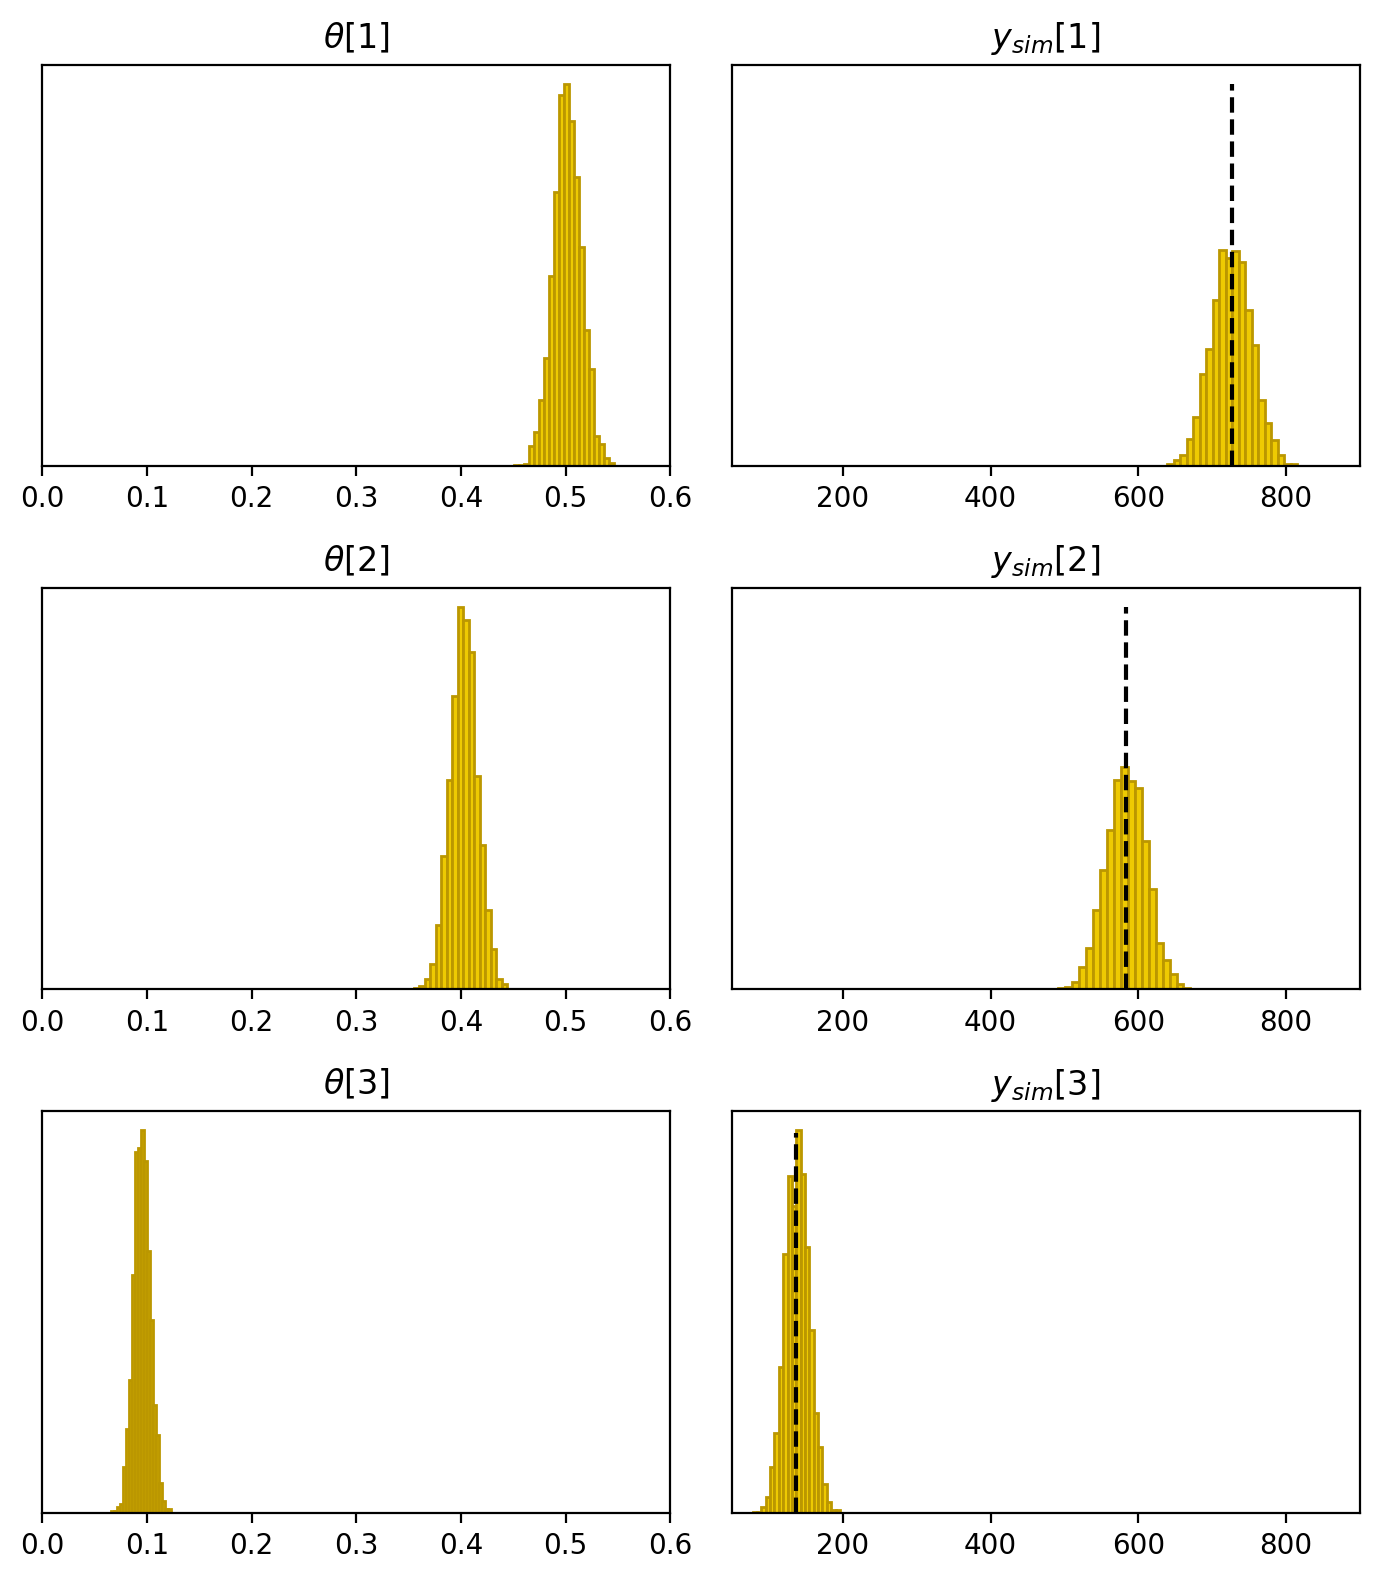

In [45]:
fig, axes = plt.subplots(3, 2, figsize=(7, 8), squeeze=False)
axes_flat=axes.flatten()
tvs=iter(data)
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(titles[k])
    if (k % 2) == 1:
        tv = next(tvs)
        ax.plot([tv,tv],[0,0.025],linestyle='--',color='black')
        ax.set_xlim([50,900])
    else:
        ax.set_xlim([0,0.6])
        
    ax.set_yticks([])
#    ax.set_xticks([0,tv,50])
#    ax.set_xticklabels([0,tv,50])
    

fig.tight_layout()

plt.show()

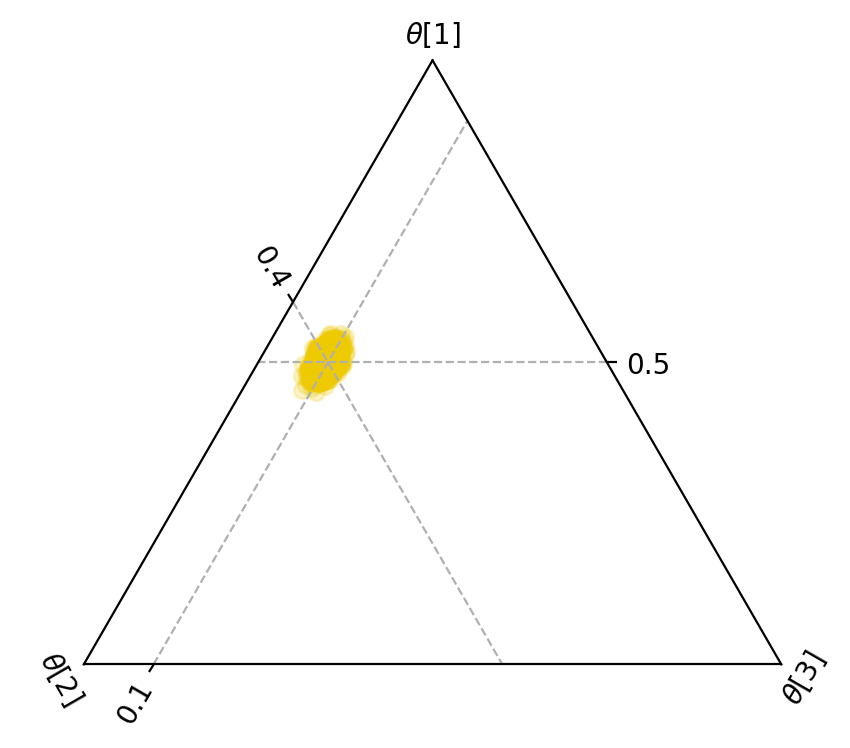

In [39]:
fig, ax_tr = plt.subplots(1, 1, figsize=(7, 4),subplot_kw={'projection':'ternary'})
ax_tr.set_tlabel(r'$\theta[1]$')
ax_tr.set_llabel(r'$\theta[2]$')
ax_tr.set_rlabel(r'$\theta[3]$')
ax_tr.taxis.set_ticks([0.5])
ax_tr.laxis.set_ticks([0.4])
ax_tr.raxis.set_ticks([0.1])
ax_tr.scatter(y_sim[:,0], y_sim[:,2], y_sim[:,4],alpha=0.2,color=dark)
ax_tr.grid(linestyle='--')

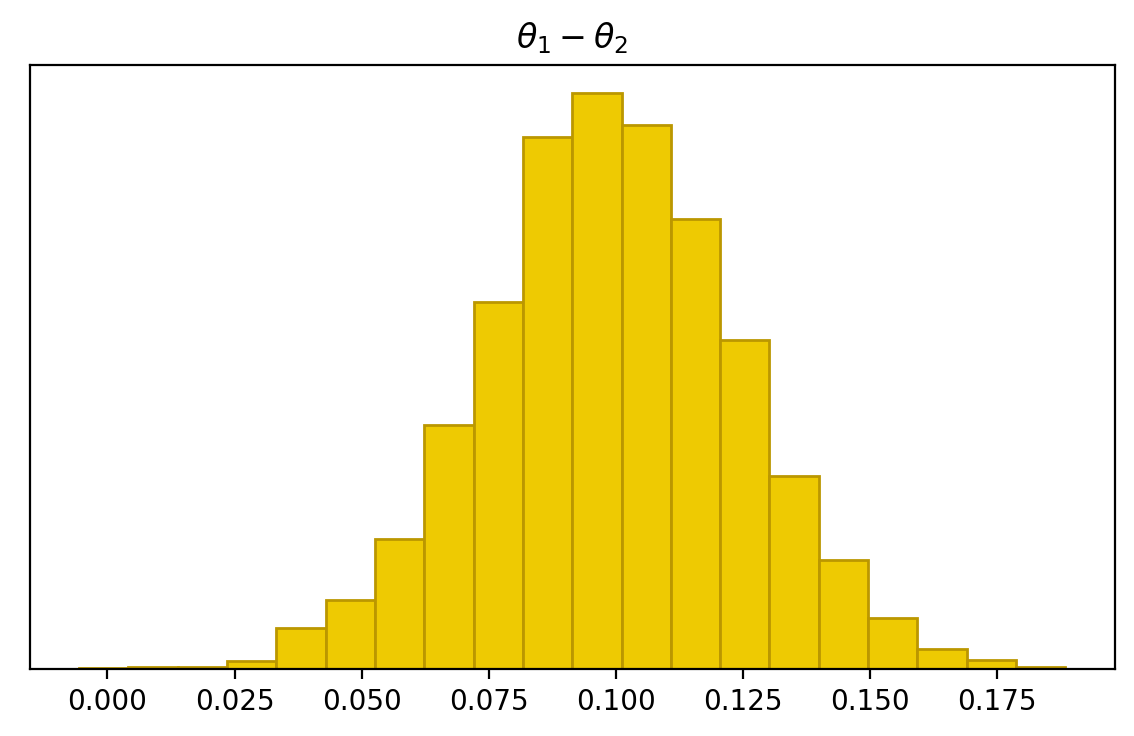

In [41]:
advantage=fit.stan_variable('advantage')
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hist(advantage,bins=20,color=dark,edgecolor=dark_highlight,density=True)
axes.set_title(r'$\theta_1-\theta_2$')
axes.set_yticks([])
plt.show()

## Probability of Dukakis winning.

In [42]:
print(np.sum([advantage<0])/4000)

0.00025


In [43]:
az.summary(fit,stat_funcs=func_dict,extend=False,var_names=['advantage'])

,median,5%,95%
advantage,0.099,0.058,0.14
